<a href="https://colab.research.google.com/github/silverstar0727/1day-1commit-challenge/blob/master/machine_learning_ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# 주택가격 데이터 불러오기
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
'python-machine-learning-book-2nd-edition'
'/master/code/ch10/housing.data.txt', header = None, sep = '\s+')

df.columns = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
            'PRTATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRTATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


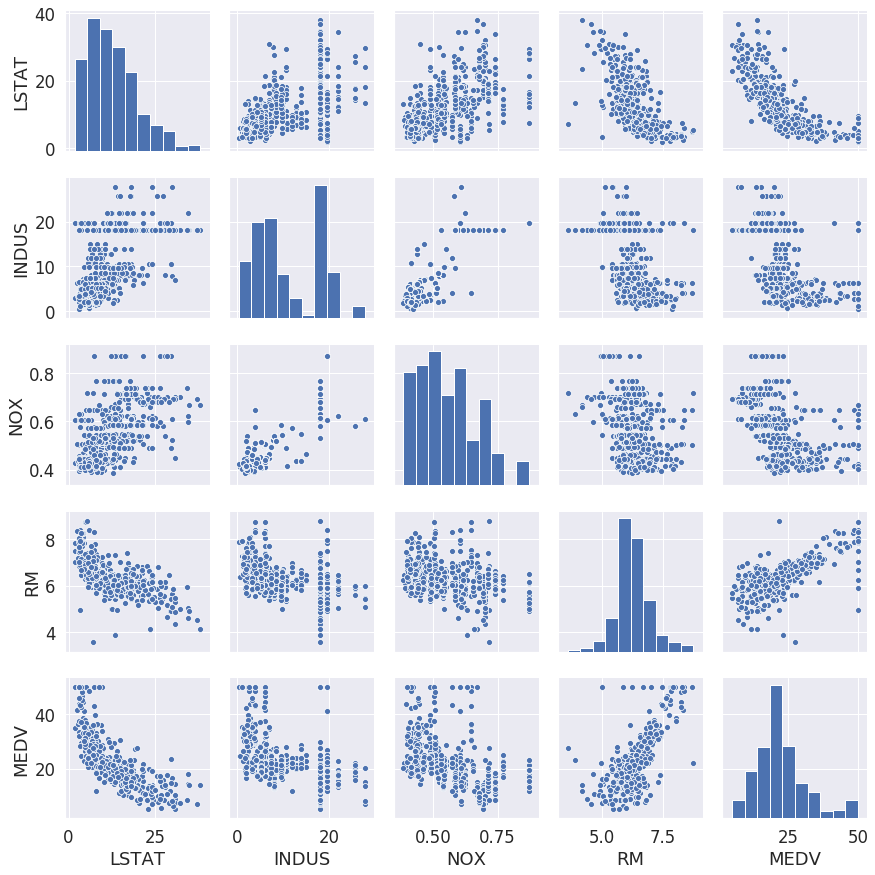

In [35]:
# 산점도 행렬
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height = 2.5)
plt.tight_layout()
plt.show()

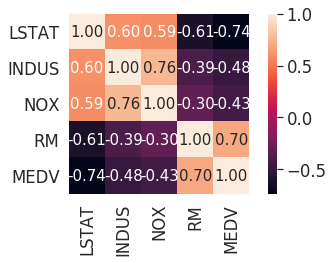

In [36]:
# heatmap을 이용한 상관관계행렬
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 15},
                 yticklabels = cols, xticklabels = cols)
plt.tight_layout()
plt.show()

In [0]:
# 최소제곱 선형회귀모델 구현

class LinearRegressionGD(object):
  def __init__(self, eta = 0.001, n_iter = 20):
    self.eta = eta
    self.n_iter = n_iter
  
  def fit(self, X, y):
    self.w_ = np.zeros(1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
      output = self.net_input(X)
      errors = (y - output)
      self.w_[1:] += self.eta * X.T.dot(errors)
      self.w_[0] += self.eta * errors.sum()
      cost = (errors ** 2).sum()/2.0
      self.cost_.append(cost)

    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:] + self.w_[0])

  def predict(self, X):
    return self.net_input(X)

In [38]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

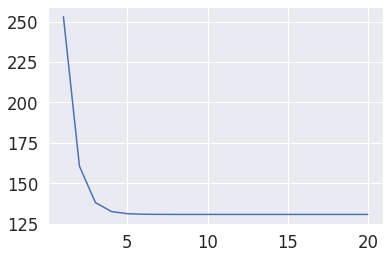

In [39]:
# epochs에 따른 SSE그래프
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.show()

In [0]:
# 산점도와 회귀직선을 그려줌

def lin_regplot(X, y, model):
  plt.scatter(X, y, c = 'steelblue', edgecolor = 'white', s = 70)
  plt.plot(X, model.predict(X), color = 'black', lw = 2)
  return None

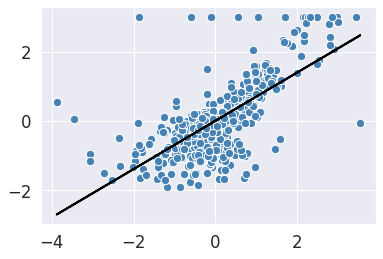

In [41]:
# 그래프 그리기
lin_regplot(X_std, y_std, lr)
plt.show()

In [42]:
# 예측가격 단위변환
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print(sc_y.inverse_transform(price_std))

[10.83993289]


In [44]:
# 가중치 출력
print('기울기: %.3f' % lr.w_[1])
print('절편: %.3f' % lr.w_[0])

기울기: 0.695
절편: -0.000


In [49]:
# 사이킷런으로 회귀분석
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
print('%.3f' % slr.coef_[0])
print('%.3f' % slr.intercept_)

9.102
-34.671


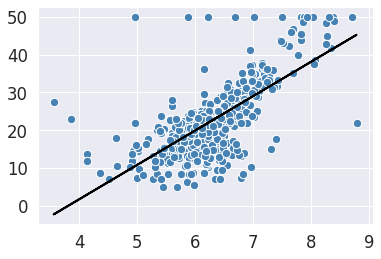

In [50]:
# 직접 만든 알고리즘과의 비교
lin_regplot(X, y, slr)
plt.show()

## RANSAC 회귀 
랜덤하게 샘플을 선택하여 훈련 후 오차안에 속한 포인트를 정상치에 추가... 이런방식이다.

In [51]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), max_trials = 100, min_samples = 50, loss = 'absolute_loss',
                         residual_threshold = 5.0, random_state = 0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=50, random_state=0,
                residual_threshold=5.0, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

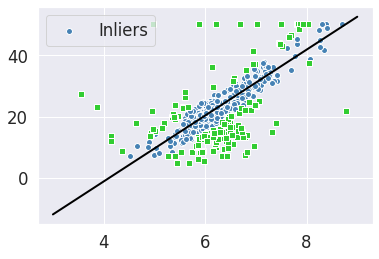

In [53]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c = 'steelblue', edgecolor = 'white', marker = 'o',
            label = 'Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c = 'limegreen', edgecolor = 'white', marker = 's')
plt.plot(line_X, line_y_ransac, color = 'black', lw = 2)
plt.legend(loc = 'upper left')
plt.show()

In [55]:
print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

기울기: 10.735
절편: -44.089


In [0]:
# 성능평가
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

No handles with labels found to put in legend.


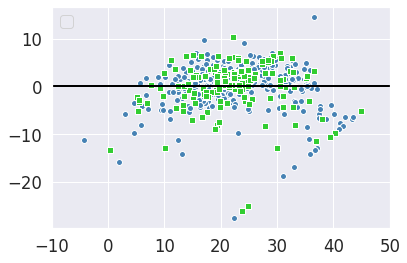

In [59]:
# 잔차그래프
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'steelblue', marker = 'o', edgecolor = 'white')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'limegreen', marker = 's', edgecolor = 'white')
plt.legend(loc = 'upper left') 
plt.hlines(y = 0, xmin = -10, xmax = 50, color = 'black', lw = 2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [60]:
# MSE계산 (mean squared error)
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred))


19.958219814238046 27.195965766883354


In [61]:
# R square
from sklearn.metrics import r2_score
print(r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred))

0.7645451026942549 0.6733825506400177
